In [1]:
# for math operations
import pandas as pd
import numpy as np

# for data preprocessing
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from shutil import copyfile

# Model building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import pickle

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('stopwords')
stemmer = PorterStemmer()
words = stopwords.words("english")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def cleanText(str):
  return ' '.join(re.sub('[^A-Za-z ]+', '', str.lower()).split()).replace('subject', '').strip()

# Preprocess datasets

In [3]:

legit_dataset_path = '../datasets/enron1/ham'
spam_dataset_path = '../datasets/enron1/spam'
combined_path = '../datasets/enron1'

legit_dataset = []
legit_label = []
spam_dataset = []
spam_label = []
for file_name in os.listdir(legit_dataset_path):
  with open(os.path.join(legit_dataset_path, file_name), 'r', encoding='utf8') as f:
    text = cleanText(f.read())
    if text:
      legit_dataset.append(text)
      legit_label.append('0')

for file_name in os.listdir(spam_dataset_path):
  with open(os.path.join(spam_dataset_path, file_name), 'r', encoding='utf8') as f:
    text = cleanText(f.read())
    if text:
      spam_dataset.append(text)
      spam_label.append('1')

train_dataset = legit_dataset + spam_dataset
train_label = legit_label + spam_label
dict = {'Text': train_dataset, 'Predict': train_label}

df = pd.DataFrame(dict)

df.to_csv(combined_path + '/train_dataset.csv')


# Load dataset

In [4]:
dataset = pd.read_csv('../datasets/enron1/train_dataset.csv')
dataset.tail()

,Unnamed: 0,Text,Predict
5142,5142,our pro forma invoice attacheddivide cover mos...,1
5143,5143,str rndlen extra time word bodyhtml,1
5144,5144,check me out bbhey dermbbbbbcheck out paris an...,1
5145,5145,hot jobsglobal marketing specialties po box ea...,1
5146,5146,save up to on ink no shipping costsave up to o...,1


In [5]:
dataset.shape

(5147, 3)

In [6]:
dataset = dataset[['Text', 'Predict']]

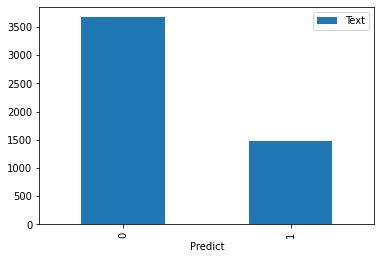

In [7]:
dataset.groupby('Predict').count().plot.bar(ylim=0)
plt.show()

# Text processing

In [8]:

dataset['Text'] = dataset['Text'].apply(
  lambda x: ' '.join([stemmer.stem(i) for i in re.sub('[^a-zA-Z]', ' ', x).split() if i not in words]))

In [9]:
dataset

,Text,Predict
0,christma tree farm pictur,0
1,vastar resourc inc gari product high island la...,0
2,calpin daili ga nomin calpin daili ga nomin doc,0
3,issuefyi see note alreadi done stella forward ...,0
4,meter nov allocationfyi forward lauri allen ho...,0
...,...,...
5142,pro forma invoic attacheddivid cover gave trip...,1
5143,str rndlen extra time word bodyhtml,1
5144,check bbhey dermbbbbbcheck pari mani celeb atbl,1
5145,hot jobsglob market specialti po box east amhe...,1


# Feature Extraction

In [10]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(dataset['Text']).toarray()
final_features.shape

(5147, 33294)

# Model building

In [11]:
X = dataset['Text']
Y = dataset['Predict']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

pipelineRF = Pipeline([('vect', vectorizer),
                    ('chi',  SelectKBest(chi2, k=1200)),
                    ('clf', RandomForestClassifier())])

pipelineNB = Pipeline([('vect', vectorizer),
                    ('chi', SelectKBest(chi2, k=1200)),
                    ('clnb', MultinomialNB())])


model_NB = pipelineNB.fit(X_train, y_train)
with open('SpamMailNB.pickle', 'wb') as f:
  pickle.dump(model_NB, f)

model_RF = pipelineRF.fit(X_train, y_train)
with open('SpamMailRF.pickle', 'wb') as f:
  pickle.dump(model_RF, f)


# Load model if exist

In [12]:
model_RF = pickle.load(open('SpamMailRF.pickle', 'rb'))
model_NB = pickle.load(open('SpamMailNB.pickle', 'rb'))

# Evaluate

In [13]:
ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print('Naive Bayes:')
print(classification_report(ytest, model_NB.predict(X_test)))
print(confusion_matrix(ytest, model_NB.predict(X_test)))
print('-----------------------------------------------------')
print('Random Forest:')
print(classification_report(ytest, model_RF.predict(X_test)))
print(confusion_matrix(ytest, model_RF.predict(X_test)))

Naive Bayes:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       378
           1       0.96      0.85      0.90       137

    accuracy                           0.95       515
   macro avg       0.95      0.92      0.93       515
weighted avg       0.95      0.95      0.95       515

[[373   5]
 [ 21 116]]
-----------------------------------------------------
Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       378
           1       0.96      0.94      0.95       137

    accuracy                           0.97       515
   macro avg       0.97      0.96      0.97       515
weighted avg       0.97      0.97      0.97       515

[[372   6]
 [  8 129]]


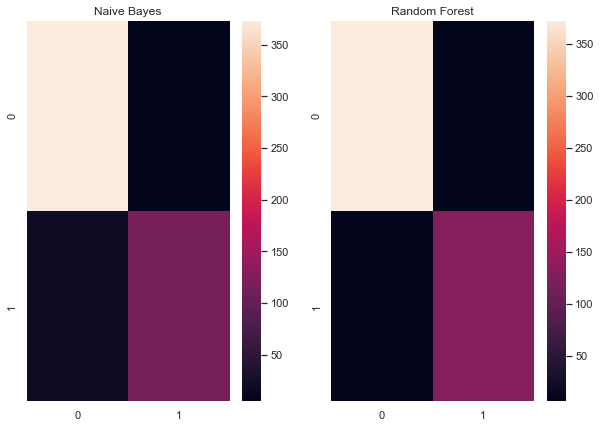

In [14]:
import seaborn as sns
sns.set()
fig, (ax1, ax2) = plt.subplots(figsize=(10, 7), ncols=2)
ax1.set_title('Naive Bayes')
ax2.set_title('Random Forest')
sns.heatmap(confusion_matrix(ytest, model_NB.predict(X_test)), ax=ax1)
sns.heatmap(confusion_matrix(ytest, model_RF.predict(X_test)), ax=ax2)

plt.show()


# Predict

In [15]:
def preprocessText(str):
  return ' '.join([stemmer.stem(i) for i in re.sub('[^a-zA-Z]', ' ', str).split() if i not in words])

Load mails to check from folder

In [16]:
mails_to_check = []
mail_names = []
predict_path = '../datasets/predict'

for file_name in os.listdir(predict_path):
  with open(os.path.join(predict_path, file_name), 'r', encoding='utf8') as f:
    text = cleanText(f.read())
    if text:
      mails_to_check.append(text)
      mail_names.append(file_name)

Predict

In [17]:
ham_path = '../datasets/non-spam'

processed_mails_to_check = []
for i in mails_to_check:
    processed_mails_to_check.append(preprocessText(i))

X_predict = np.array(processed_mails_to_check)

# make a prediction
y_predict_NB = model_NB.predict(X_predict)
y_predict_RF = model_RF.predict(X_predict)

evaluate_NB = 0
evaluate_RF = 0
for i in range(len(mail_names)):
    print('Naive Bayes: {} - Random Forest: {} - Mail {}'.format('Spam' if y_predict_NB[i] == 1 else 'Legit', 'Spam' if y_predict_RF[i] == 1 else 'Legit', mail_names[i]))
    if ('spam' in mail_names[i] and y_predict_NB[i] == 1) or ('ham' in mail_names[i] and y_predict_NB[i] == 0):
        evaluate_NB += 1
    if ('spam' in mail_names[i] and y_predict_RF[i] == 1) or ('ham' in mail_names[i] and y_predict_RF[i] == 0):
        evaluate_RF += 1
    if y_predict_RF[i] == 0:
        copyfile(predict_path + "/" + mail_names[i], ham_path + "/" + mail_names[i])

print('\nHit ratio:')
print('Naive Bayes: {}/{}'.format(evaluate_NB, len(mail_names)))
print('Random Forest: {}/{}'.format(evaluate_RF, len(mail_names)))
print('Finished Copying legit mails to /non-spam folder for domain prediction step')

Naive Bayes: Spam - Random Forest: Legit - Mail 0011.2001-06-29.SA_and_HP.spam.txt
Naive Bayes: Spam - Random Forest: Spam - Mail 0013.2001-06-30.SA_and_HP.spam.txt
Naive Bayes: Spam - Random Forest: Spam - Mail 0015.2003-12-19.GP.spam.txt
Naive Bayes: Spam - Random Forest: Spam - Mail 0032.2003-12-22.GP.spam.txt
Naive Bayes: Spam - Random Forest: Spam - Mail 0033.2003-12-22.GP.spam.txt
Naive Bayes: Spam - Random Forest: Spam - Mail 0034.2003-12-22.GP.spam.txt
Naive Bayes: Spam - Random Forest: Spam - Mail 0046.2004-08-03.BG.spam.txt
Naive Bayes: Legit - Random Forest: Legit - Mail 0049.2001-04-06.williams.ham.txt
Naive Bayes: Legit - Random Forest: Legit - Mail 0053.2001-04-07.williams.ham.txt
Naive Bayes: Legit - Random Forest: Legit - Mail 0063.2001-02-23.kitchen.ham.txt
Naive Bayes: Spam - Random Forest: Legit - Mail 0064.2001-02-23.kitchen.ham.txt
Naive Bayes: Legit - Random Forest: Legit - Mail 0065.2001-02-23.kitchen.ham.txt
Naive Bayes: Spam - Random Forest: Spam - Mail 0265.20